In [18]:
import torch
from torchvision import datasets, transforms, models  # datsets  , transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

In [4]:
vgg_mean = [0.485, 0.456, 0.406]
vgg_std = [0.229, 0.224, 0.225]
transform2 = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),  # Reduced from 15°
    transforms.ColorJitter(brightness=0.15, contrast=0.15),  # Reduced variation
    transforms.ToTensor(),
    transforms.Normalize(mean=vgg_mean, std=vgg_std)
])

In [6]:
dataset_vgg=datasets.ImageFolder("/kaggle/input/mepco-tropic-leaf/MepcoTropicLeaf-V1/Database", transform=transform2)

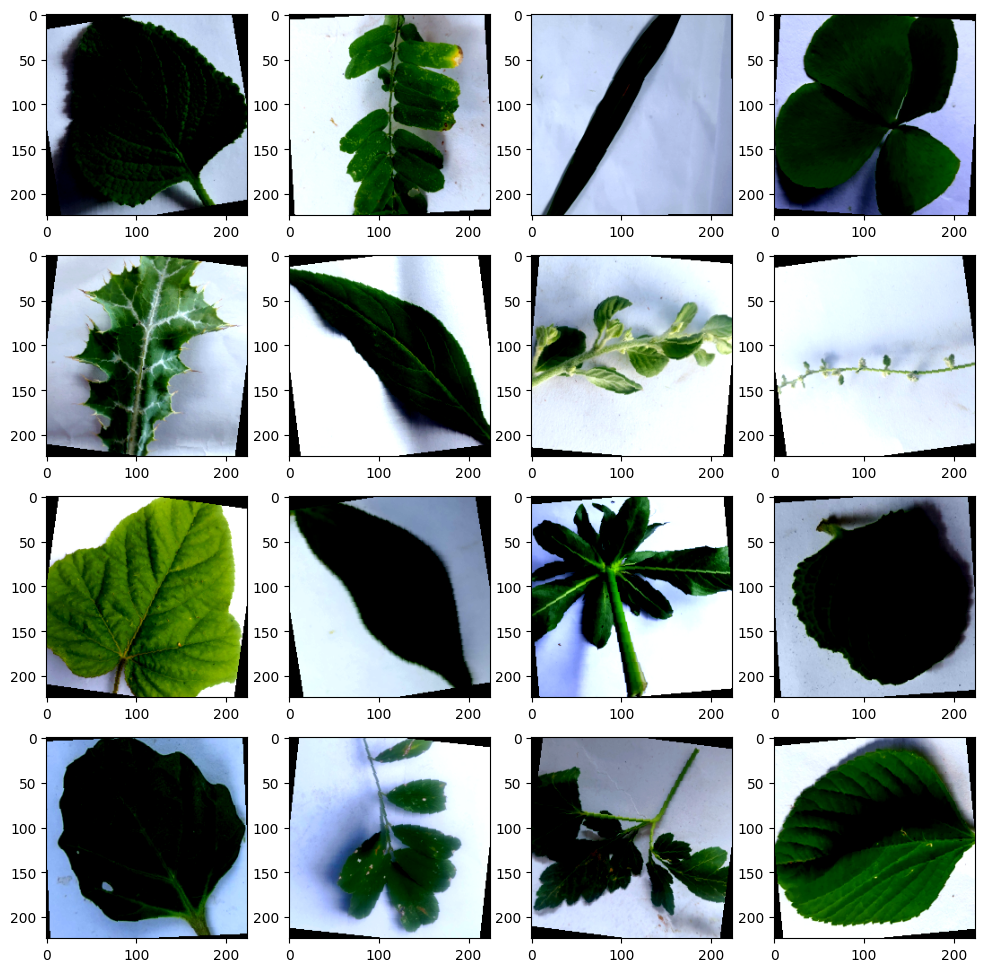

In [7]:
# Visualize augmented samples
temp_loader = torch.utils.data.DataLoader(dataset_vgg, batch_size=16, shuffle=True)
images, _ = next(iter(temp_loader))
plt.figure(figsize=(12,12))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(images[i].permute(1,2,0).numpy()*0.5+0.5)  # Un-normalize
plt.show()

In [8]:
indices=list(range(len(dataset_vgg))) # dataset ko numerate karne ke liye
split=int(np.floor(0.70*len(dataset_vgg)))
validation=int(np.floor(0.60*split))

# agar tmre pass 100 samples hai
# toh split=70(ie 70% of the dataset)-> ee use hoga training and validation ke liye; remaining (30)30% used hoga as test set
# tb validation=42 (ie 60% of the dataset)-> ee use hoga for training ke liye; remaining (28)40% used hoga as Validation set
# toh phir training= 42%; validation= 28%; test=30%

print(f"length of train size : {validation}")
print(f"length of validation size : {split-validation}")
print(f"length of test size : {len(dataset_vgg)-split}")

np.random.shuffle(indices) # dataset me randomness laane ke liye

# ab actual splitting
train_indices, validation_indices, test_indices = (
    indices[:validation], # [:5]->0,1,2,3,4
    indices[validation:split],# [1:3]->1,2
    indices[split:],# [2:]-> 2,3,4,5,........
)

train_sampler = SubsetRandomSampler(train_indices)
validation_sampler = SubsetRandomSampler(validation_indices)
test_sampler = SubsetRandomSampler(test_indices)

# print(list(train_indices))
# print(list(validation_indices))
# print(list(test_indices))

# print(list(train_sampler))
# print(list(validation_sampler))
# print(list(test_sampler))


length of train size : 1585
length of validation size : 1058
length of test size : 1134


In [9]:
targets_size = len(dataset_vgg.class_to_idx)# finding the total unique classes and storing it
print(targets_size)
print(list(dataset_vgg.class_to_idx.keys()))
num_classes_list = list(dataset_vgg.class_to_idx.values())# now numerating them
print(num_classes_list)

50
['Asthma Plant.zip', 'Avaram.zip', 'Balloon vine.zip', 'Bellyache bush (Green).zip', 'Benghal dayflower.zip', 'Big Caltrops.zip', 'Black-Honey Shrub.zip', 'Bristly Wild Grape.zip', 'Butterfly Pea.zip', 'Cape Gooseberry.zip', 'Common Wireweed.zip', 'Country Mallow.zip', 'Crown flower.zip', 'Green Chireta.zip', 'Holy Basil.zip', 'Indian CopperLeaf.zip', 'Indian Jujube.zip', 'Indian Sarsaparilla.zip', 'Indian Stinging Nettle.zip', 'Indian Thornapple.zip', 'Indian wormwood.zip', 'Ivy Gourd.zip', 'Kokilaksha.zip', 'Land Caltrops (Bindii).zip', 'Madagascar Periwinkle.zip', 'Madras Pea Pumpkin.zip', 'Malabar Catmint.zip', 'Mexican Mint.zip', 'Mexican Prickly Poppy.zip', 'Mountain Knotgrass.zip', 'Nalta Jute.zip', 'Night blooming Cereus.zip', 'Panicled Foldwing.zip', 'Prickly Chaff Flower.zip', 'Punarnava.zip', 'Purple Fruited Pea Eggplant.zip', 'Purple Tephrosia.zip', 'Rosary Pea.zip', 'Shaggy button weed.zip', 'Small Water Clover.zip', 'Spiderwisp.zip', 'Square Stalked Vine.zip', 'Stinkin

In [10]:
# Replace your model loading with this:
model3 = models.vgg16(pretrained=True)

# Freeze early layers (keep BatchNorm trainable)
for name, param in model3.named_parameters():
    if 'features' in name and 'weight' in name:  # Freeze only conv weights
        param.requires_grad = False

model3.classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(0.6),  # Reduced from 0.7
    nn.Linear(4096, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(0.6),  # Reduced from 0.7
    nn.Linear(4096, 50)
)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 178MB/s]  


In [11]:
n_features = model3.classifier[0].in_features #vgg16; number of input features in the first fully connected layer
n_features

25088

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device) #checking if GPU is available
model3.to(device)

cuda


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [13]:
criterion = nn.CrossEntropyLoss()  # this include softmax + cross entropy loss
# calculates the loss during training, which will be later used by backpropagation to imporove the models accuracy
optimizer = torch.optim.Adam(model3.parameters(), lr=0.0001, weight_decay=5e-5)  # Reduced L2
#adam optimiser is used to optimise the models parameters(weights of the model) to minimise the loss and hence increase the accuracy

In [14]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    dataset_vgg, batch_size=batch_size, sampler=train_sampler
)
test_loader = torch.utils.data.DataLoader(
    dataset_vgg, batch_size=batch_size, sampler=test_sampler
)
validation_loader = torch.utils.data.DataLoader(
    dataset_vgg, batch_size=batch_size, sampler=validation_sampler
)

In [15]:
def plot_losses(train_losses, test_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss', color='blue', marker='o')
    plt.plot(test_losses, label='Validation Loss', color='red', marker='x')
    plt.title('Training and Validation Losses', fontsize=16)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [16]:
def batch_gd_new(model3, criterion, train_loader, test_loader, epochs):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    
    # Memory tracking initialization
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        mem_before = torch.cuda.memory_allocated() / 1024**2  # MB
    
    # Track average inference time
    total_inference_time = 0
    inference_count = 0
    
    for e in range(epochs):
        t0 = datetime.now()
        train_loss = []
        
        # Training phase
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Measure inference time
            start_time = time.time()
            optimizer.zero_grad()
            output = model3(inputs)
            inference_time = time.time() - start_time
            
            total_inference_time += inference_time
            inference_count += 1
            
            loss = criterion(output, targets)
            train_loss.append(loss.item())
            loss.backward()
            optimizer.step()

        train_loss = np.mean(train_loss)
        test_loss = []
        
        # Validation phase
        model3.eval()
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                output = model3(inputs)
                loss = criterion(output, targets)
                test_loss.append(loss.item())
        model3.train()

        test_loss = np.mean(test_loss)
        train_losses[e] = train_loss
        test_losses[e] = test_loss
        
        dt = datetime.now() - t0
        print(f"Epoch {e+1}/{epochs} Train loss: {train_loss:.4f} Val loss: {test_loss:.4f} Duration: {dt}")

    # Memory and timing results
    avg_inference_time = total_inference_time / inference_count if inference_count > 0 else 0
    print(f"\nTraining Summary:")
    print(f"Average inference time per batch: {avg_inference_time:.4f} seconds")
    
    if torch.cuda.is_available():
        mem_after = torch.cuda.memory_allocated() / 1024**2
        mem_used = mem_after - mem_before
        print(f"GPU Memory used: {mem_used:.2f} MB")
    
    return train_losses, test_losses

Epoch 1/20 Train loss: 0.2704 Val loss: 0.4217 Duration: 0:00:56.600655
Epoch 2/20 Train loss: 0.2085 Val loss: 0.4222 Duration: 0:00:56.876241
Epoch 3/20 Train loss: 0.1644 Val loss: 0.4051 Duration: 0:00:56.756617
Epoch 4/20 Train loss: 0.1507 Val loss: 0.3751 Duration: 0:00:56.448570
Epoch 5/20 Train loss: 0.1175 Val loss: 0.3714 Duration: 0:00:57.397709
Epoch 6/20 Train loss: 0.0921 Val loss: 0.3354 Duration: 0:00:56.749596
Epoch 7/20 Train loss: 0.0808 Val loss: 0.3690 Duration: 0:00:56.924139
Epoch 8/20 Train loss: 0.0747 Val loss: 0.3413 Duration: 0:00:56.496235
Epoch 9/20 Train loss: 0.0834 Val loss: 0.3072 Duration: 0:00:56.687780
Epoch 10/20 Train loss: 0.0642 Val loss: 0.3417 Duration: 0:00:56.532057
Epoch 11/20 Train loss: 0.0641 Val loss: 0.3749 Duration: 0:00:56.483646
Epoch 12/20 Train loss: 0.0463 Val loss: 0.3600 Duration: 0:00:56.356163
Epoch 13/20 Train loss: 0.0418 Val loss: 0.3025 Duration: 0:00:56.435003
Epoch 14/20 Train loss: 0.0418 Val loss: 0.3467 Duration: 0:

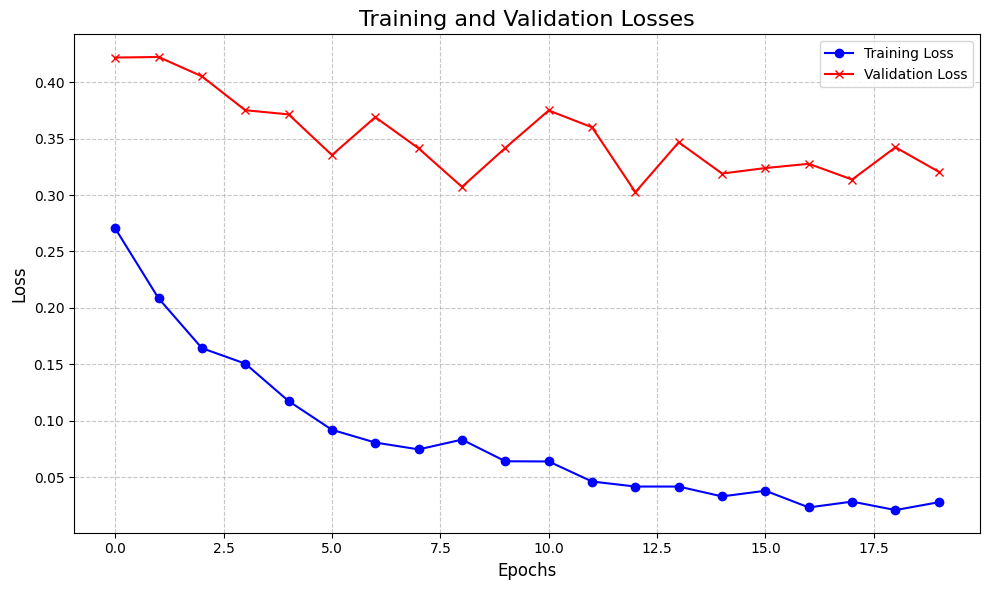

In [24]:
train_losses, test_losses= batch_gd_new(model3, criterion, train_loader, validation_loader, 20)
plot_losses(train_losses, test_losses)

In [26]:
def accuracy(loader):
    n_correct = 0
    n_total = 0
    model3.cuda()
    for inputs, targets in loader:
        inputs, targets = inputs.cuda(), targets.cuda()
        outputs = model3(inputs)
        #print(outputs)
        _, predictions = torch.max(outputs, 1)
        n_correct += (predictions == targets).sum().item()
        n_total += targets.shape[0]

    acc = n_correct / n_total
    return acc

In [25]:
train_acc = accuracy(train_loader)
test_acc = accuracy(test_loader)
validation_acc = accuracy(validation_loader)

print(
    f"Train Accuracy : {train_acc}\nTest Accuracy : {test_acc}\nValidation Accuracy : {validation_acc}"
)

Train Accuracy : 0.9917981072555205
Test Accuracy : 0.8686067019400353
Validation Accuracy : 0.8771266540642723
